In [792]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as kr
import librosa as lib
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn.metrics as sk
import seaborn as sns

In [793]:
# Data processing
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "/dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]

testSet = valid_data.sample(n=100, random_state=100)
testSet.to_csv("../test_set.csv")

trainingSet = valid_data.drop(testSet.index)
trainingSet.to_csv("../training_set.csv")
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "../dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]
processingSet
FRAME_SIZE = 512 # the size of the frame
HOP_LENGTH = 256 # the distance each frame jumps by
FRAME_LENGTH = 512 # length of a frame

def getFeatures(audioSignal, sample_rate):
    
    # duration of 1 sample
    oneSampleDuration = 1/sample_rate
    
    # duration of audio signal in seconds
    sampleDuration = oneSampleDuration*len(audioFile)
    
    ae, time = getAmplitudeEnvelope(audioSignal)
    rms = getRMS(audioSignal)
    zcr = getZCR(audioSignal)
    
    return time, ae, rms, zcr
    
def getAmplitudeEnvelope(audioSignal):
    amplitudeEnvelope = []
    
    for i in range(0, len(audioSignal), HOP_LENGTH):
        currentFrameAE = max(audioSignal[i:i+FRAME_SIZE])
        amplitudeEnvelope.append(currentFrameAE)
        
    amplitudeEnvelope = np.array(amplitudeEnvelope)
    amplitudeFrames = range(0, amplitudeEnvelope.size)
    time = lib.frames_to_time(amplitudeFrames, hop_length=HOP_LENGTH)
    
    return amplitudeEnvelope, time
    
def getRMS(audioSignal):
    rms = []
    for i in range(0, len(audioSignal), HOP_LENGTH):
        rms_current = np.sqrt(np.sum(audioSignal[i:i+FRAME_LENGTH]**2) / FRAME_LENGTH)
        rms.append(rms_current)
    return rms

def getZCR(audioSignal):
    return lib.feature.zero_crossing_rate(audioSignal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

def calc_sfb(spec, freq, sr):
    freq_range = sr/2
    freq_delta = freq_range / spec.shape[0]
    return int(np.floor(freq / freq_delta))
def calc_ber(spec, freq, sr):
    sfb = calc_sfb(spec, freq, sr)
    pSpec = np.abs(spec) ** 2
    pSpec = pSpec.T
    ber = []

    for freqs in pSpec:
        sum_low = np.sum(freqs[:sfb])
        sum_high = np.sum(freqs[sfb:])
        ber_current = sum_low/sum_high
        ber.append(ber_current)

    return np.array(ber)
def getFrequencyFeatures(audioSignal, sample_rate):
    audio_spec = lib.stft(audioFile, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    centroid = lib.feature.spectral_centroid(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    bandwidth = lib.feature.spectral_bandwidth(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    ber = calc_ber(audio_spec, 2000, sample_rate)
    return centroid, bandwidth, ber

zeroCrossingRateList = []
amplitudeEnvelopeList = []
rootMeanSquareEnergyList = []
spectralCentroidList = []
spectralBandwidthList = []
bandEnergyRatioList = []
timings = []
audioFileLengths = []

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    audioFileLengths.append(len(audioFile))

maxAudioLength = max(audioFileLengths)    

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    audioFile = lib.util.pad_center(audioFile, size=maxAudioLength)
    time, ae, rmse, zcr = getFeatures(audioFile, sample_rate)
    centroid, bandwidth, ber = getFrequencyFeatures(audioFile, sample_rate)
    zeroCrossingRateList.append(zcr)
    amplitudeEnvelopeList.append(ae)
    rootMeanSquareEnergyList.append(rmse)
    spectralCentroidList.append(centroid)
    spectralBandwidthList.append(bandwidth)
    bandEnergyRatioList.append(ber)
    timings.append(time)
    
processingSet["Timings"] = timings
processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
processingSet["Root_Mean_Square_Energy"] = rootMeanSquareEnergyList
processingSet["Zero-Crossing Rate"] = zeroCrossingRateList
processingSet["Spectral Centroid"] = spectralCentroidList
processingSet["Spectral Bandwidth"] = spectralBandwidthList
processingSet["Band Energy Ratio"] = bandEnergyRatioList
trainingSetProcessed = processingSet.drop(testSet.index)
testSetProcessed = processingSet.drop(trainingSetProcessed.index)
processingSet

C:\Users\ellis\AppData\Local\Temp\ipykernel_69776\115148476.py:79: RuntimeWarning: invalid value encountered in scalar divide
  ber_current = sum_low/sum_high
C:\Users\ellis\AppData\Local\Temp\ipykernel_69776\115148476.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Timings"] = timings
C:\Users\ellis\AppData\Local\Temp\ipykernel_69776\115148476.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
C:\Users\ellis\AppData\Local\T

,affect,file_path,phone_position,Timings,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing Rate,Spectral Centroid,Spectral Bandwidth,Band Energy Ratio
0,sadness,../dataset/shout_data_3afd7208-7987-4c73-8e01-...,Place phone on the opposite side of the room i...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,neutral,../dataset/shout_data_ae6feb35-cf7a-4805-8d05-...,Hold your phone next to your face but with the...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,disgust,../dataset/shout_data_739dbf1c-ec21-42db-9e49-...,Place phone 1-2 meters away face up on any sur...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...,...,...,...,...,...,...
3048,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3049,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3050,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..

Recurrent Neural Network
========================

In [794]:
emotions = {"neutral": 0, "anger": 1, "joy":2, "fear":3, "disgust":4, "surprise": 5, "sadness": 6}
emotions2 = {"Neutral": 0, "Anger": 1, "Joy":2, "Fear":3, "Disgust":4, "Surprise": 5, "Sadness": 6}
positions = {"Hold your phone next to your face with the mic facing your mouth as you would in a phone conversation 1/19": 0,
            "Hold your phone next to your face but with the mic/phone facing away from your face 2/19": 1,
            "Hold your phone next to your face with your hand covering the mic 3/19": 2,
            "Hold your phone next to your hip with the back of phone on your palm 4/19": 3,
            "Hold your phone next to your hip with your hand covering the mic 5/19": 4,
            "Place your phone in your pocket 6/19": 5,
            "Place your phone in a bag and hold it next to your hip 7/19": 6,
            "Place phone 1-2 meters away face up on any surface 8/19": 7,
            "Place phone 1-2 meters away face down on a hard surface 9/19": 8,
            "Place phone 1-2 meters away face down on a soft surface 10/19": 9,
            "Place phone 1-2 meters away in a bag 11/19": 10,
            "Place phone on the opposite side of the room face up on any surface 12/19": 11,
            "Place phone on the opposite side of the room face down on a hard surface 13/19": 12,
            "Place phone on the opposite side of the room face down on a soft surface 14/19": 13,
            "Place phone on the opposite side of the room in a bag 15/19": 14,
            "Place phone as far away as possible while on on the opposite side of a wall from you face up on any surface 16/19": 15,
            "Place phone as far away as possible while on on the opposite side of a wall from you face down on a hard surface 17/19": 16,
            "Place phone as far away as possible while on on the opposite side of a wall from you face down on a soft surface 18/19": 17,
            "Place phone as far away as possible while on on the opposite side of a wall from you in a bag 19/19": 18}

In [795]:
# Read in processed audio data
validSet = trainingSetProcessed.sample(n = 100, random_state=100)
trainSet = trainingSetProcessed.drop(validSet.index)
testSet = testSetProcessed
validSet["phone_position"] = validSet["phone_position"].map(positions)
trainSet["phone_position"] = trainSet["phone_position"].map(positions)
testSet["phone_position"] = testSet["phone_position"].map(positions)
trainSetY = trainSet['affect']
trainSetY = trainSetY.map(emotions)
validSetY = validSet['affect']
validSetY = validSetY.map(emotions)
testSetY = testSet['affect']
testSetY = testSetY.map(emotions)

In [796]:
# Process feature data into an input
trainData = []
trainDataP = []
for datapoint in np.array(trainSet[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth", "phone_position"]]):
    AE, RMSE, ZCR, SC, SB, P = datapoint
    trainData.append([AE, RMSE, ZCR, SC, SB])
    trainDataP.append([P])
trainX = np.array(trainData)
trainXP = np.array(trainDataP)
validData = []
validDataP = []
for datapoint in np.array(validSet[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth", "phone_position"]]):
    AE, RMSE, ZCR, SC, SB, P = datapoint
    validData.append([AE, RMSE, ZCR, SC, SB])
    validDataP.append([P])
validX = np.array(validData)
validXP = np.array(validDataP)
testData = []
testDataP = []
for datapoint in np.array(testSet[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth", "phone_position"]]):
    AE, RMSE, ZCR, SC, SB, P = datapoint
    testData.append([AE, RMSE, ZCR, SC, SB])
    testDataP.append([P])
testX = np.array(testData)
testXP = np.array(testDataP)

In [797]:
trainXT = tf.convert_to_tensor(trainX)
trainSetY = kr.utils.to_categorical(trainSetY, num_classes=7)
trainYT = tf.convert_to_tensor(trainSetY)
validXT = tf.convert_to_tensor(validX)
validSetY = kr.utils.to_categorical(validSetY, num_classes=7)
validYT = tf.convert_to_tensor(validSetY)
testXT = tf.convert_to_tensor(testX)
testSetY = kr.utils.to_categorical(testSetY, num_classes=7)
testYT = tf.convert_to_tensor(testSetY)
trainXPT = tf.convert_to_tensor(trainXP)
validXPT = tf.convert_to_tensor(validXP)
testXPT = tf.convert_to_tensor(testXP)

Emotion Recognition

In [712]:
# Construct the Recurrent Neural Net
RNN = kr.Sequential()
RNN.add(kr.layers.Input(shape=(5, len(trainingSetProcessed["Timings"][0]))))
RNN.add(kr.layers.SimpleRNN(250, return_sequences=True))
RNN.add(kr.layers.SimpleRNN(100, return_sequences=True))
RNN.add(kr.layers.SimpleRNN(25))
RNN.add(kr.layers.Dropout(0.01))
RNN.add(kr.layers.Dense(64, activation='relu'))
RNN.add(kr.layers.Dense(32, activation='relu'))
RNN.add(kr.layers.Dense(7, activation='softmax'))
sgd = kr.optimizers.SGD(0.001)
RNN.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
RNN.summary()

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_216 (SimpleRNN)      │ (None, 5, 250)         │       222,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_217 (SimpleRNN)      │ (None, 5, 100)         │        35,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_218 (SimpleRNN)      │ (None, 25)             │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,725 (1.01 MB)

 Trainable params: 264,725 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [713]:
# Fit the Recurrent Neural Net to the Data
RNN.fit(trainXT, trainYT, validation_data=(validXT, validYT), epochs=20, batch_size=150)
# Evaluate the Recurrent Neural Net
print()
RNN.evaluate(testXT, testYT)

Epoch 1/20


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1358 - loss: 1.9929 - val_accuracy: 0.1300 - val_loss: 1.9698
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1606 - loss: 1.9630 - val_accuracy: 0.1600 - val_loss: 1.9727
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1406 - loss: 1.9587 - val_accuracy: 0.0800 - val_loss: 1.9630
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1314 - loss: 1.9576 - val_accuracy: 0.1700 - val_loss: 1.9588
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1515 - loss: 1.9503 - val_accuracy: 0.2200 - val_loss: 1.9363
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1467 - loss: 1.9581 - val_accuracy: 0.2100 - val_loss: 1.9506
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1559 - loss: 1.9484 - val_accuracy: 0.1800 - val_loss: 1.9526
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1458 - loss: 1.9509 - val_accuracy: 0.1900 - val_loss: 1.9416
Ep

[1.9748376607894897, 0.14000000059604645]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
              precision    recall  f1-score   support

           0       0.10      0.07      0.08        15
           1       0.11      0.27      0.15        11
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        15
           5       0.15      0.62      0.25        13
           6       0.40      0.12      0.19        16

    accuracy                           0.14       100
   macro avg       0.11      0.15      0.10       100
weighted avg       0.11      0.14      0.09       100



<Axes: >

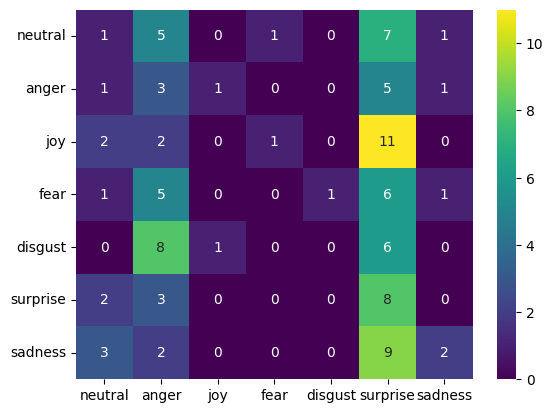

In [714]:
predict = np.argmax(RNN.predict(testXT), axis=1)
testYT = np.argmax(testYT, axis=1)
print(sk.classification_report(testYT, predict))
cm = sk.confusion_matrix(testYT, predict)
cmDisplay = pd.DataFrame(data=cm, columns=['neutral', 'anger', 'joy', 'fear', 'disgust', 'surprise', 'sadness'], index=['neutral', 'anger', 'joy', 'fear', 'disgust', 'surprise', 'sadness'])
sns.heatmap(cmDisplay, annot=True, fmt='d', cmap='viridis')

In [715]:
annotated_data = pd.read_csv("../test_set_annotated.csv")
testAY = annotated_data["Actual_Determined_Label"]
testAY = testAY.map(emotions2)
testAY = kr.utils.to_categorical(testAY, num_classes=7)
testAYT = tf.convert_to_tensor(testAY)
# Fit the Recurrent Neural Net to the Data
RNN.fit(trainXT, trainYT, validation_data=(validXT, validYT), epochs=20, batch_size=100)
# Evaluate the Recurrent Neural Net
print()
RNN.evaluate(testXT, testAYT)
predict = np.argmax(RNN.predict(testXT), axis=1)
testAYT = np.argmax(testAYT, axis=1)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1572 - loss: 1.9423 - val_accuracy: 0.1500 - val_loss: 1.9660
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1594 - loss: 1.9429 - val_accuracy: 0.1300 - val_loss: 1.9571
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1704 - loss: 1.9422 - val_accuracy: 0.1600 - val_loss: 1.9541
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1658 - loss: 1.9410 - val_accuracy: 0.1500 - val_loss: 1.9509
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1643 - loss: 1.9387 - val_accuracy: 0.1100 - val_loss: 1.9507
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1675 - loss: 1.9387 - val_accuracy: 0.2000 - val_loss: 1.9455
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1662 - loss: 1.9394 - val_accuracy: 0.1400 - val_loss: 1.9607
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1664 - loss: 1.9377 - val_accuracy: 0.1200 - val_loss:

Text(50.722222222222214, 0.5, 'Actual Label')

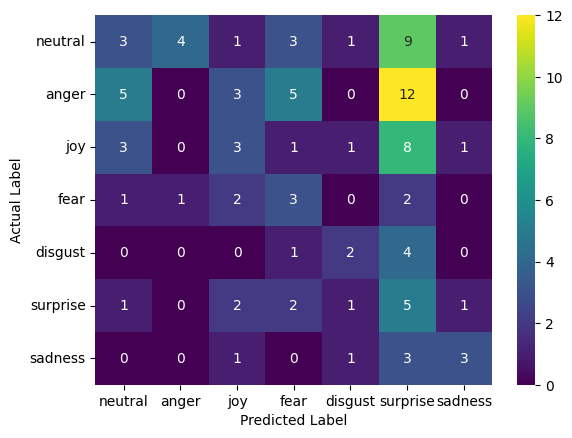

In [716]:
cm = sk.confusion_matrix(testAYT, predict)
cmDisplay = pd.DataFrame(data=cm, columns=['neutral', 'anger', 'joy', 'fear', 'disgust', 'surprise', 'sadness'], index=['neutral', 'anger', 'joy', 'fear', 'disgust', 'surprise', 'sadness'])
sns.heatmap(cmDisplay, annot=True, fmt='d', cmap='viridis')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

In [717]:
print(sk.classification_report(testAYT, predict ,zero_division=0))

              precision    recall  f1-score   support

           0       0.23      0.14      0.17        22
           1       0.00      0.00      0.00        25
           2       0.25      0.18      0.21        17
           3       0.20      0.33      0.25         9
           4       0.33      0.29      0.31         7
           5       0.12      0.42      0.18        12
           6       0.50      0.38      0.43         8

    accuracy                           0.19       100
   macro avg       0.23      0.25      0.22       100
weighted avg       0.19      0.19      0.17       100



Position Detection

In [ ]:
# Construct the Recurrent Neural Net
RNN = kr.Sequential()
RNN.add(kr.layers.Input(shape=(6, len(trainingSetProcessed["Timings"][0]))))
RNN.add(kr.layers.SimpleRNN(250, return_sequences=True))
RNN.add(kr.layers.SimpleRNN(100, return_sequences=True))
RNN.add(kr.layers.SimpleRNN(25))
RNN.add(kr.layers.Dropout(0.01))
RNN.add(kr.layers.Dense(64, activation='relu'))
RNN.add(kr.layers.Dense(32, activation='relu'))
RNN.add(kr.layers.Dense(7, activation='softmax'))
sgd = kr.optimizers.SGD(0.001)
RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
RNN.summary()

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_225 (SimpleRNN)      │ (None, None, 250)      │        63,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_226 (SimpleRNN)      │ (None, None, 100)      │        35,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_227 (SimpleRNN)      │ (None, 25)             │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,475 (412.01 KB)

 Trainable params: 105,475 (412.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the Recurrent Neural Net to the Data
RNN.fit(trainXPT, trainYT, validation_data=(validXPT, validYT), epochs=20, batch_size=200)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 2), dtype=float32). Expected shape (None, None, 2), but input has incompatible shape (None, 2)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 2), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Evaluate the Recurrent Neural Net
RNN.evaluate(testXPT, testYT)